In [1]:
import os
import numpy as np
import json
import cv2
import random
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog

from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultPredictor

## Register dataset

In [2]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "val"]:
    register_coco_instances("ucb_gait_{}".format(d), {}, 
                            "/home/josmar/proyectos/codes/datasets/ucb_gait_frames/annotations/ucb_gait_{}.json".format(d),
                            "/home/josmar/proyectos/codes/datasets/ucb_gait_frames/images")
    MetadataCatalog.get("ucb_gait_" + d).set(thing_classes=["person"])
ucb_gait_metadata = MetadataCatalog.get("ucb_gait_train")
print(ucb_gait_metadata)

Metadata(evaluator_type='coco', image_root='/home/josmar/proyectos/codes/datasets/ucb_gait_frames/images', json_file='/home/josmar/proyectos/codes/datasets/ucb_gait_frames/annotations/ucb_gait_train.json', name='ucb_gait_train', thing_classes=['person'])


In [3]:
import random
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get("ucb_gait_train")


/home/josmar/proyectos/codes/datasets/ucb_gait_frames/images/023-031.jpg


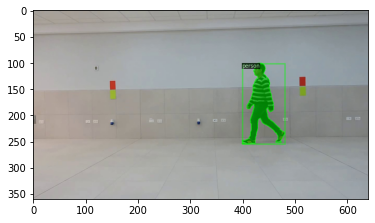

/home/josmar/proyectos/codes/datasets/ucb_gait_frames/images/005-076.jpg


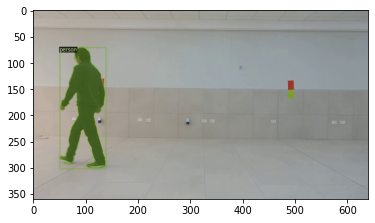

/home/josmar/proyectos/codes/datasets/ucb_gait_frames/images/025-016.jpg


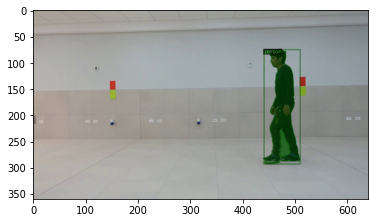

In [4]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=ucb_gait_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    print(d["file_name"])
    plt.imshow(vis.get_image())
    plt.show()

In [5]:
dataset_dicts = DatasetCatalog.get("ucb_gait_val")
print(dataset_dicts[0].keys())

dict_keys(['file_name', 'height', 'width', 'image_id', 'annotations'])


## Training

In [6]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
)
cfg.DATASETS.TRAIN = ("ucb_gait_train",)
cfg.DATASETS.TEST = ()  # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = (
    300
)  # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (
    128
)  # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 1 class (person)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/07 14:57:24 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

## Prediction

In [7]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("ucb_gait_val", )
predictor = DefaultPredictor(cfg)

[11/07 14:59:12 d2.data.datasets.coco]: Loaded 1230 images in COCO format from /home/josmar/proyectos/codes/datasets/ucb_gait_frames/annotations/ucb_gait_val.json


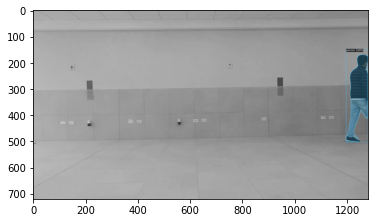

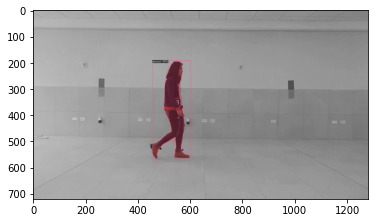

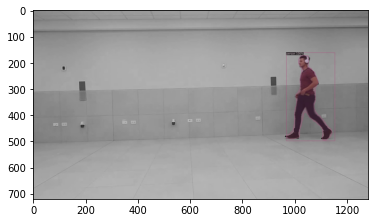

In [8]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("ucb_gait_val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=ucb_gait_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image())
    plt.show()

## Evaluate

In [9]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("ucb_gait_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "ucb_gait_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[11/07 14:59:15 d2.data.datasets.coco]: Loaded 1230 images in COCO format from /home/josmar/proyectos/codes/datasets/ucb_gait_frames/annotations/ucb_gait_val.json
[11/07 14:59:15 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   person   | 1230         |
|            |              |
[11/07 14:59:15 d2.data.common]: Serializing 1230 elements to byte tensors and concatenating them all ...
[11/07 14:59:15 d2.data.common]: Serialized dataset takes 29.74 MiB
[11/07 14:59:15 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/07 14:59:15 d2.evaluation.evaluator]: Start inference on 1230 images
[11/07 14:59:16 d2.evaluation.evaluator]: Inference done 11/1230. 0.0686 s / img. ETA=0:01:27
[11/07 14:59:21 d2.evaluation.evaluator]: Inference done 79/1230. 0.0691 s / img. ETA=0:01:24
[11/07 14:59:26 d2.evaluation.evaluato

OrderedDict([('bbox',
              {'AP': 75.55256423585264,
               'AP50': 98.21061004718287,
               'AP75': 96.1260800179495,
               'APs': 10.469606772041363,
               'APm': 31.48535610789359,
               'APl': 77.09897365000622}),
             ('segm',
              {'AP': 77.21275794674078,
               'AP50': 98.39085263834193,
               'AP75': 96.77760962754309,
               'APs': 7.967681623012152,
               'APm': 36.84473738994305,
               'APl': 78.5876619132907})])